# Изпользование статистики CUSUM для нахождения момента разладки

Пусть изветсно, что последовательность независимых случайных величин $\xi_1, \xi_2, \dots$ до (неизвестного) момента времени $\theta$ имела плотность распределения $f(x)$, а после -- $g(x)$. Наша задача -- аппроксимировать время $\theta$, называемое также моментом разладки.

Функцию правдоподобия в предположении, что момент разладки наступил в момент времени $\theta$ запишем в следующем виде:
$$L(x_1, x_2, \dots | \theta) = \prod_{i = 1}^{\theta - 1}f(x_i) \prod_{i = \theta}^{\infty} g(x_i)$$

Статистику CUSUM будем искать по формуле:

$$S_k = \max_{1 \leq i \leq k} \log \frac{L(x_1, x_2, ... | i)}{L(x_1, x_2, ... | \infty)}$$

Это определение эквивалентно вот такому:

$$S_0 = 0$$
$$S_k = \max(0, S_{k - 1} + \log \frac{g(x_k)}{f(x_k)})$$

А момент разладки

$$\tau_{\alpha} = \min\{k: S_k \geq \alpha\}$$

При это $\alpha$ выбирается экспериментально.

## Визуализация данных

В файлах <i>times1.txt</i> и <i>times2.txt</i> нам дана выборка времени загрузки страницы некоторого сайта. При этом для файла times1.txt момент разладки известен -- это <b>8445</b>. Сначала опишем необходимые нам впоследствии функции.

<font color = "FF0000">
Еще лучше в данном случае считывать файл с помощью <b>numpy.loadtxt</b>.
</font>

In [3]:
%matplotlib inline
import scipy.stats as stats
import matplotlib.pyplot as plot
import math
import numpy

#Чтение данных и форматирование из файла filename
def read_data(filename):
    with open(filename) as f:
        values = [float(x) for x in f.read().splitlines()]
    return values
#Экспоненциальное сглаживание с параметром alpha
def exp_smooth(values, alpha):
    S = []
    for value in values:
        if (len(S) == 0):
            S.append(value)
        else:
            S.append(alpha * value + (1 - alpha) * S[-1])
    return S

#Вызов distribution.fit для первых before_percentile % списка values
def fit_before(values, before_percentile, distribution):
    n = int(len(values)*before_percentile)
    slice = values[0:n]
    return distribution.fit(slice)

#Вызов distribution.fit для последних after_percentile % списка values
def fit_after(values, after_percentile, distribution):
    n = int(len(values)*after_percentile)
    slice = values[n:-1]
    return distribution.fit(slice)

#Рассчёт статистики CUSUM
def cusum_statistics(values, logpdf_before, logpdf_after):
    S = [0]
    for value in values:
        new_S = max(0, S[-1] + logpdf_after(value) - logpdf_before(value))
        S.append(new_S)
    return S

Нарисуем сначала временную развёртку первого набора данных

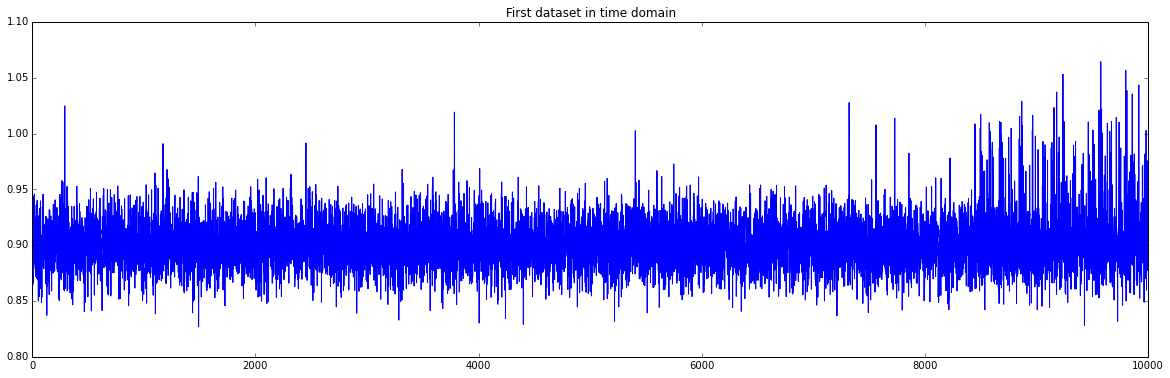

In [12]:
values = read_data("times1.txt")
plot.figure(figsize=(20,6))
plot.title('First dataset in time domain')
plot.plot(values)
plot.show()

Вообще, момент разладки лучше видно при маленьком масштабе.

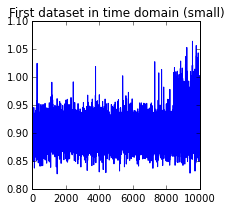

In [13]:
values = read_data("times1.txt")
plot.figure(figsize=(3, 3))
plot.title('First dataset in time domain (small)')
plot.plot(values)
plot.show()

что-то похожее на <b>8445</b> можно заметить на графике в качестве момента разладки. Возьмём первые 50% и последние 15%, где разладки точно нет (есть) и нарисуем гистограммы.

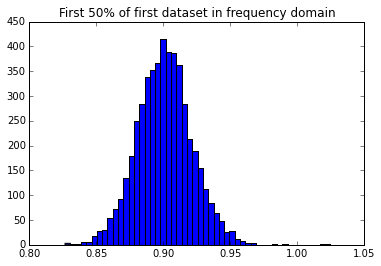

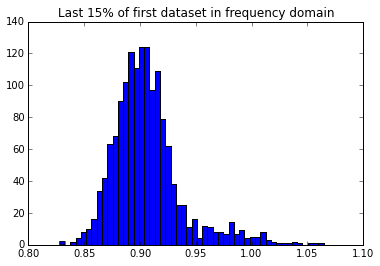

In [14]:
values = read_data("times1.txt")
plot.figure()
plot.title("First 50% of first dataset in frequency domain")
plot.hist(values[0:5000], bins = 50)
plot.show()

plot.figure()
plot.title("Last 15% of first dataset in frequency domain")
plot.hist(values[8500:-1], bins = 50)
plot.show()

Похоже, первые 50% распределены нормально, распределение же последних 15% отличается от нормального каким-от экспоненциальным куском. Будем для аппроксимации первой плотности использовать <a href="http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm">scipy.stats.norm</a>, а для второй -- <a href="http://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.exponnorm.html#scipy.stats.exponnorm">scipy.stats.exponnorm</a>. Теперь аналогично визуализируем второй датасет. Из графиков видно, что момент разладки лежит где-то между 2000 и 3000

<font color = "FF0000">
Неплохая идея. Но здесь все же была смесь двух нормальных.
</font>

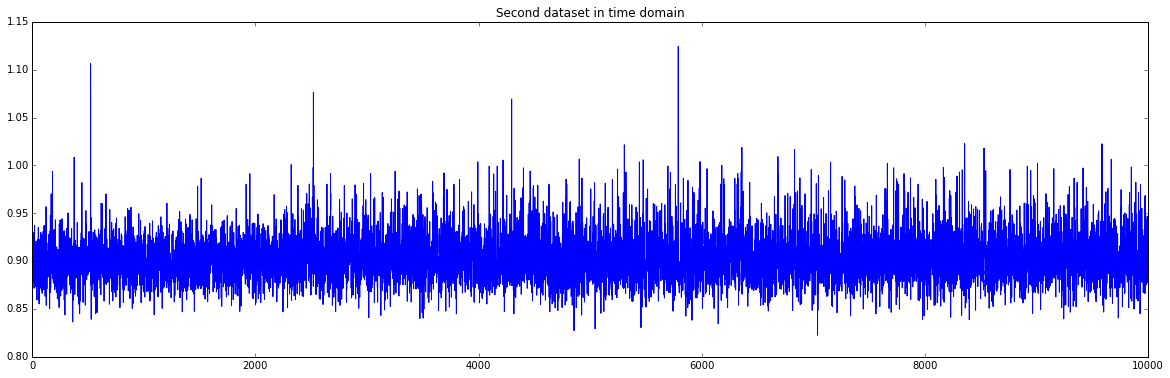

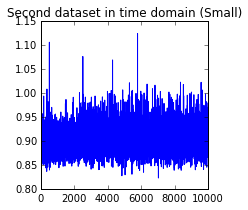

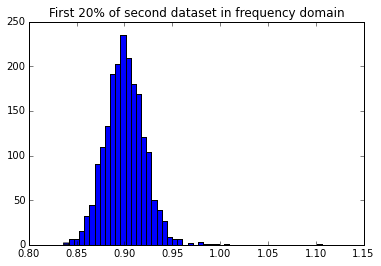

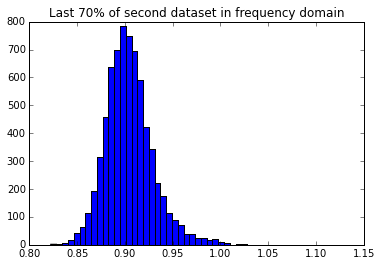

In [33]:
values = read_data("times2.txt")

plot.figure(figsize=(20,6))
plot.title('Second dataset in time domain')
plot.plot(values)
plot.show()

plot.figure(figsize=(3, 3))
plot.title('Second dataset in time domain (Small)')
plot.plot(values)
plot.show()

plot.figure()
plot.title("First 20% of second dataset in frequency domain")
plot.hist(values[0:2000], bins = 50)
plot.show()
plot.figure()
plot.title("Last 70% of second dataset in frequency domain")
plot.hist(values[3000:-1], bins = 50)
plot.show()

Теперь попытаемся найти параметры распределений norm и exponnorm с помощью [distribution].fit, который использует метот максимального правдоподобия.

In [35]:
values = read_data("times2.txt")
params_before = fit_before(values, 0.2, stats.norm)
params_after = fit_after(values, 0.7, stats.exponnorm)

print(params_before)
print(params_after)

(0.90017919260000012, 0.020894781639149887)
(1.0201015448466488, 0.88696615707048698, 0.01745399815152103)


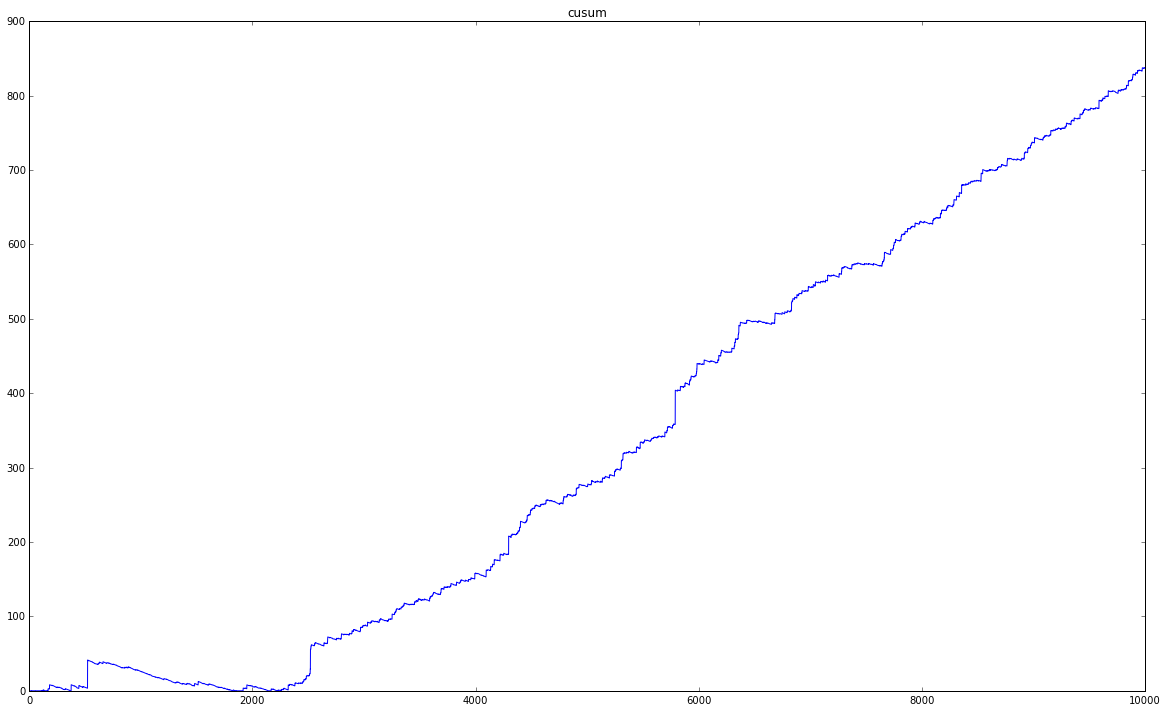

Момент разладки: 2521


In [36]:
alpha = 50

values = read_data("times2.txt")
logpdf_before = lambda x: stats.norm.logpdf(x, loc = params_before[0], scale = params_before[1])
logpdf_after = lambda x: stats.exponnorm.logpdf(x, K = params_after[0], loc = params_after[1], scale = params_after[2])

#values = exp_smooth(values, 0.8)

cusum = cusum_statistics(values, logpdf_before, logpdf_after)

answer = 0

for i in range(1, len(cusum)):
    if (cusum[i] >= alpha):
        answer = i
        break

plot.figure(figsize=(20, 12))
plot.title('cusum')
plot.plot(cusum)
plot.show()
print("Момент разладки: " + str(answer))

<font color = "FF0000">
Истинное значение $2364$.
</font>

Попробуем проделать аналогичное с данными по паре EUR/USD.

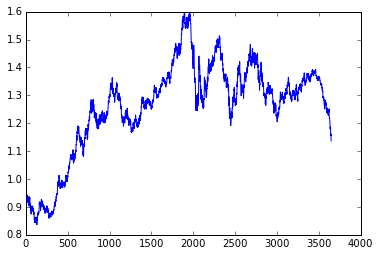

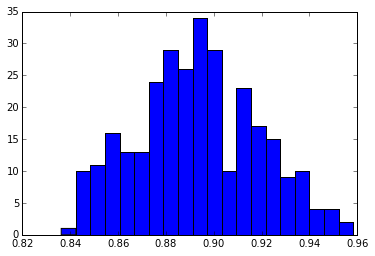

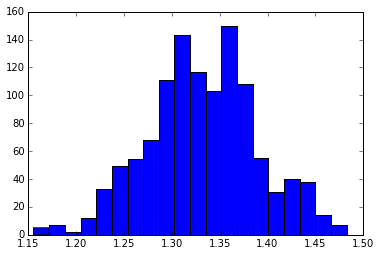

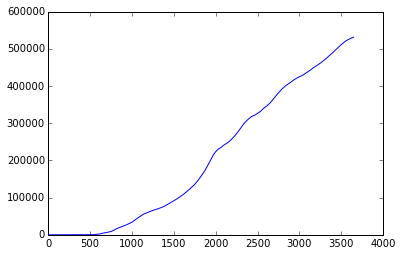

Момент разладки: 524 (дней с 1 января 2001)


In [42]:
eurusd = read_data("eurusd.csv")
plot.figure()
plot.plot(eurusd)
plot.show()

plot.figure()
plot.hist(eurusd[0:300], bins=20)
plot.show()

plot.figure()
plot.hist(eurusd[2500:-1], bins=20)
plot.show()

before = stats.norm.fit(eurusd[0:100])
after = stats.norm.fit(eurusd[2500:-1])

logpdfbefore = lambda x: stats.norm.logpdf(x, before[0], before[1])
logpdfafter = lambda x: stats.norm.logpdf(x, after[0], after[1])

cusum_eurusd = cusum_statistics(eurusd, logpdfbefore, logpdfafter)
plot.figure()
plot.plot(cusum_eurusd)
plot.show()

answer_eurusd = 0
alpha_eurusd = 1000

for i in range(1, len(cusum_eurusd)):
    if (cusum_eurusd[i] >= alpha):
        answer_eurusd = i
        break
        
print("Момент разладки: " + str(answer_eurusd) + " (дней с 1 января 2001)")

Конец.

<font color = "FF0000">
А остальные? Здесь явные разладки это пики, впадины.
</font>